# Import Library

In [ ]:
# Instalasi library yang diperlukan
!pip install torch torchvision torchaudio pytorch-lightning --quiet
!pip install ultralytics --quiet  # Untuk YOLOv5/YOLOv8
!pip install opencv-python-headless --quiet
!pip install fiftyone
print("Semua library berhasil diinstal!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 47.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of motor to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 8.3 MB/s eta 0:00:00
   ━━

In [ ]:
# Import library yang diperlukan
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from ultralytics import YOLO
from PIL import Image
import cv2
import numpy as np
from tqdm import tqdm
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor

print("Semua library berhasil di-import!")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Semua library berhasil di-import!


# Preprare Dataset

## Import Dataset Person from COCO dataset Val 2017
import menggunakan library fiftyone untuk mengambil gambar val dengan label person

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset(
    "coco-2017",
    splits=["validation"],
    classes=["person"],
)

INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/root/fiftyone/coco-2017/validation' if necessary


INFO:fiftyone.utils.coco:Downloading annotations to '/root/fiftyone/coco-2017/tmp-download/annotations_trainval2017.zip'


 100% |██████|    1.9Gb/1.9Gb [16.8s elapsed, 0s remaining, 121.2Mb/s]      


INFO:eta.core.utils: 100% |██████|    1.9Gb/1.9Gb [16.8s elapsed, 0s remaining, 121.2Mb/s]      


Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_val2017.json'


INFO:fiftyone.utils.coco:Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_val2017.json'


INFO:fiftyone.utils.coco:Downloading 2693 images


 100% |████████████████| 2693/2693 [27.5m elapsed, 0s remaining, 1.5 images/s]      


INFO:eta.core.utils: 100% |████████████████| 2693/2693 [27.5m elapsed, 0s remaining, 1.5 images/s]      


Writing annotations for 2693 downloaded samples to '/root/fiftyone/coco-2017/validation/labels.json'


INFO:fiftyone.utils.coco:Writing annotations for 2693 downloaded samples to '/root/fiftyone/coco-2017/validation/labels.json'


Dataset info written to '/root/fiftyone/coco-2017/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/coco-2017/info.json'


Loading 'coco-2017' split 'validation'


INFO:fiftyone.zoo.datasets:Loading 'coco-2017' split 'validation'


 100% |███████████████| 2693/2693 [20.4s elapsed, 0s remaining, 166.5 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 2693/2693 [20.4s elapsed, 0s remaining, 166.5 samples/s]      


Dataset 'coco-2017-validation' created


INFO:fiftyone.zoo.datasets:Dataset 'coco-2017-validation' created


menghitung data yang berlabel person

In [ ]:
# Filter untuk hanya menyertakan anotasi dengan label "person"
person_view = dataset.filter_labels("ground_truth", fo.ViewField("label") == "person")

# Verifikasi jumlah sampel dengan bounding box "person"
print(f"Number of samples with 'person': {len(person_view)}")


Number of samples with 'person': 2693


## Visualizing Image and Annotations

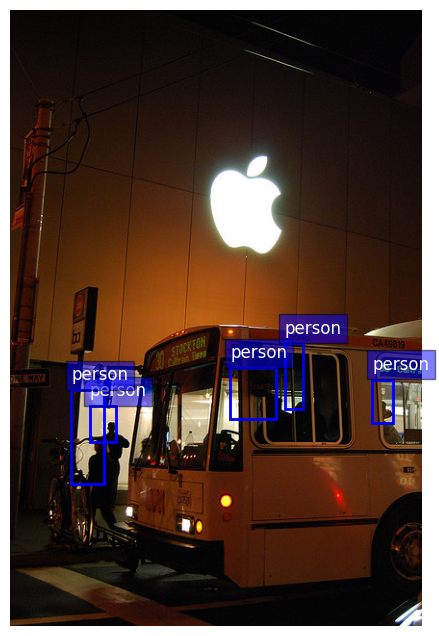

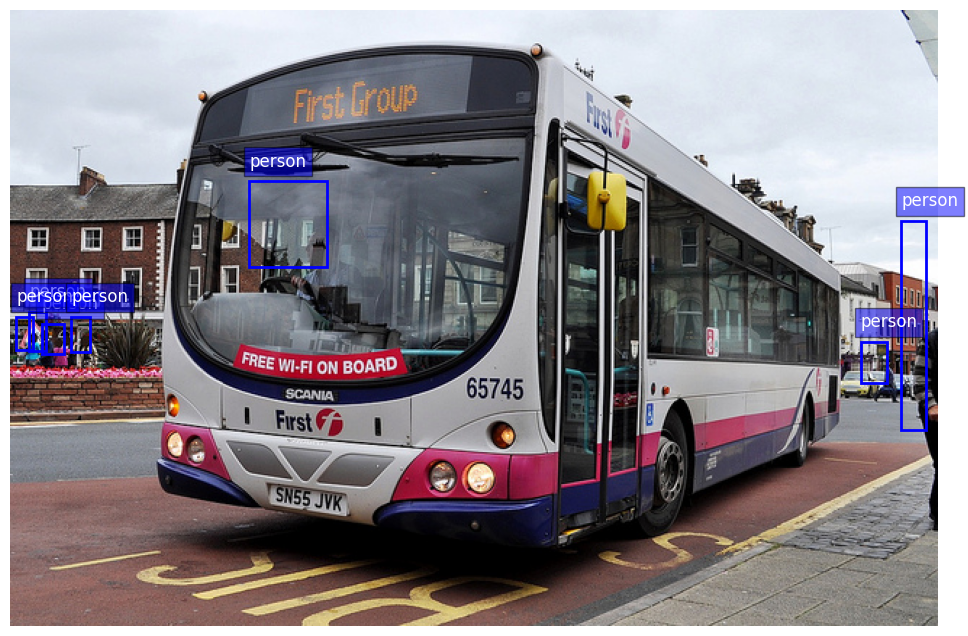

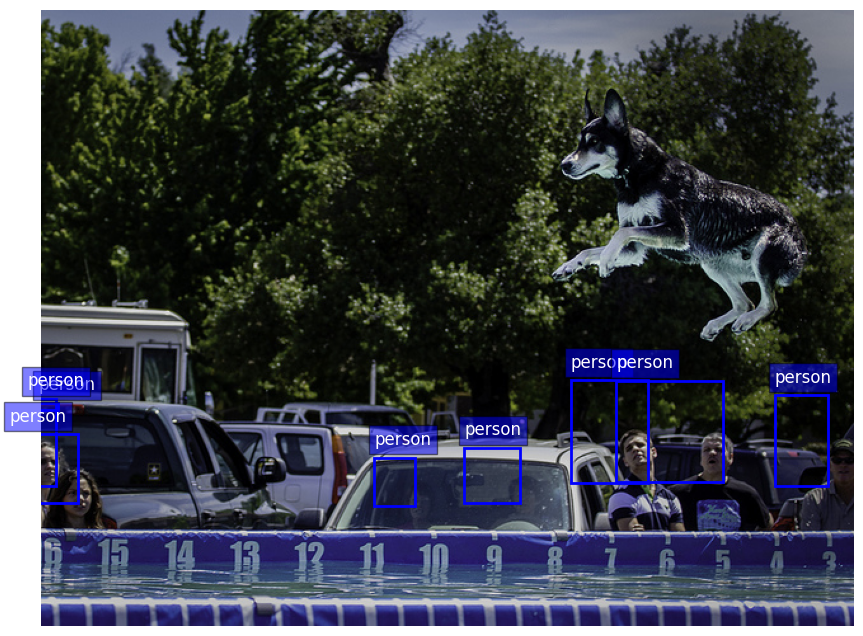

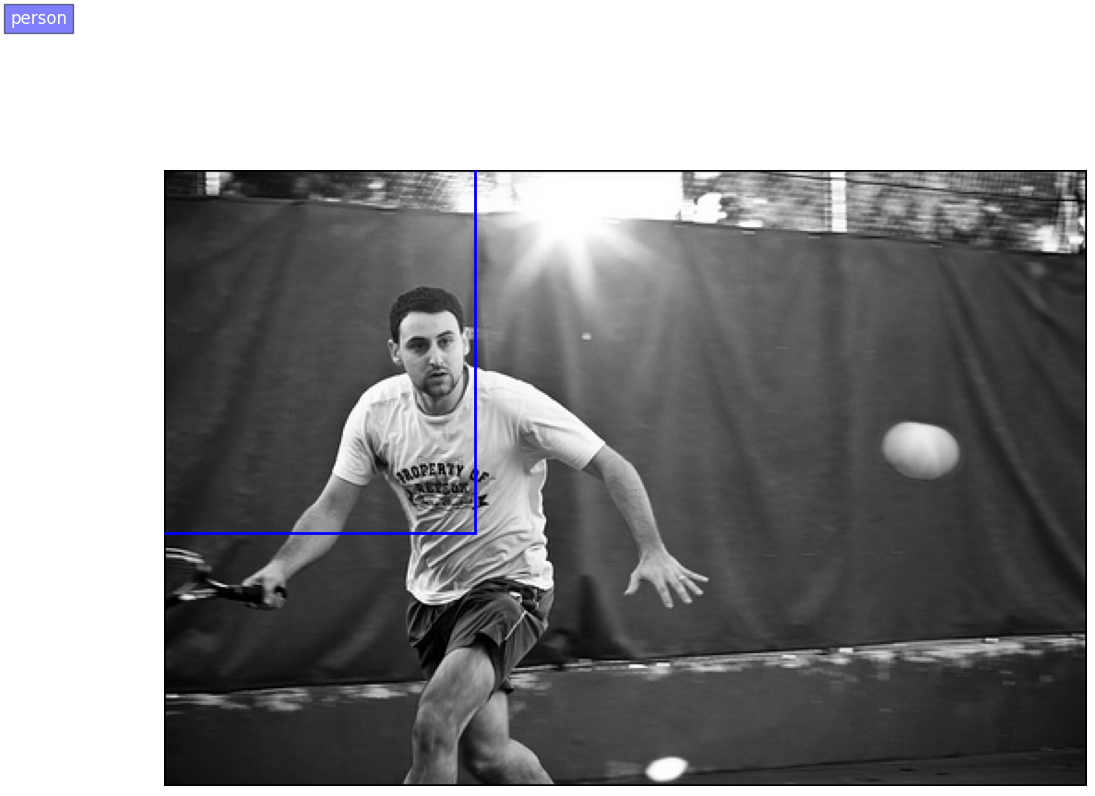

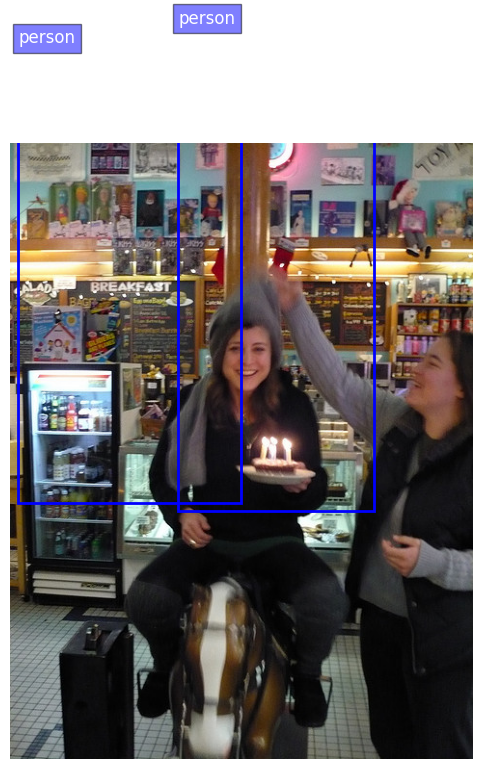

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Tampilkan beberapa gambar dengan bounding box "person"
for sample in person_view.take(5):  # Ambil 5 sampel pertama
    img_path = sample.filepath
    img = Image.open(img_path)
    detections = sample.ground_truth.detections

    # Buat plot
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)

    for detection in detections:
        label = detection.label
        bbox = detection.bounding_box  # [x, y, width, height] (YOLO format)

        # Konversi ke koordinat gambar
        x_center, y_center, width, height = bbox
        x = (x_center - width / 2) * img.width
        y = (y_center - height / 2) * img.height
        w = width * img.width
        h = height * img.height

        # Gambar bounding box
        rect = patches.Rectangle(
            (x, y), w, h, linewidth=2, edgecolor="blue", facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(x, y - 10, label, color="white", fontsize=12, bbox=dict(facecolor="blue", alpha=0.5))

    plt.axis("off")
    plt.show()


## Splitting Dataset

In [ ]:
import os
import random
import shutil

source_dir = "/content/yolo_person_dataset/images/val"
train_ratio = 0.8

# Create the train and test directories if they don't exist
train_dir = os.path.join(source_dir, "train")
test_dir = os.path.join(source_dir, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Function to get all image files in the directory and its subdirectories
def get_image_files(directory):
    image_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Include image formats
                image_files.append(os.path.join(root, file))
    return image_files

# Get all image files in the source directory and its subdirectories
image_files = get_image_files(source_dir)

# Check if image files are found
if not image_files:
    print("No image files found in the source directory or its subdirectories.")
else:
    # Shuffle the image files randomly
    random.shuffle(image_files)

    # Calculate the split index based on the desired ratio
    split_index = int(len(image_files) * train_ratio)

    # Split the image files into train and test sets
    train_files = image_files[:split_index]
    test_files = image_files[split_index:]

    # Move the image files to their respective directories
    for source_path in train_files:
        filename = os.path.basename(source_path)  # Extract filename
        destination_path = os.path.join(train_dir, filename)
        shutil.move(source_path, destination_path)

    for source_path in test_files:
        filename = os.path.basename(source_path)  # Extract filename
        destination_path = os.path.join(test_dir, filename)
        shutil.move(source_path, destination_path)

    # Print a summary of the data split
    print(f"\nData splitting complete. Train set size: {len(train_files)}, Test set size: {len(test_files)}")
    print("\nSample of files in the Train set:")
    print([os.path.basename(f) for f in train_files[:5]])  # Displaying a sample of 5 filenames from the train set

    print("\nSample of files in the Test set:")
    print([os.path.basename(f) for f in test_files[:5]])  # Displaying a sample of 5 filenames from the test set


No image files found in the source directory or its subdirectories.


In [ ]:
# Direktori ekspor
export_dir = "/content/yolo_person_dataset/images/val/"

# Ekspor dataset ke format YOLO
person_view.export(
    export_dir=export_dir,
    dataset_type=fo.types.YOLOv5Dataset,
    label_field="ground_truth",
)
print(f"Dataset exported to {export_dir}")


Directory '/content/yolo_person_dataset/images/val/' already exists; export will be merged with existing files


 100% |███████████████| 2693/2693 [8.3s elapsed, 0s remaining, 408.5 samples/s]       


INFO:eta.core.utils: 100% |███████████████| 2693/2693 [8.3s elapsed, 0s remaining, 408.5 samples/s]       


Dataset exported to /content/yolo_person_dataset/images/val/


# Create Model

Inisialisasi model yolo

In [ ]:
# YOLO Training
def train_yolo():
    # Load model YOLO versi terbaru (YOLOv8)
    model = YOLO('yolov8s.pt')
    print("Model YOLO berhasil dimuat!")
    return model

# Inisialisasi model
yolo_model = train_yolo()


100%|██████████| 21.5M/21.5M [00:00<00:00, 360MB/s]

Model YOLO berhasil dimuat!


## Train Model

In [ ]:
import yaml

optimizers = ['Adam']
epochs = [20]
batch_sizes = [16]

for optimizer in optimizers:
    for epoch in epochs:
        for batch_size in batch_sizes:
            print(f"Training with optimizer: {optimizer}, epochs: {epoch}, batch size: {batch_size}")

            # Load model YOLO versi terbaru (YOLOv8)
            model = YOLO('yolov8s.pt')  # Menggunakan YOLOv8 model kecil
            print("Model YOLO berhasil dimuat!")

            # Buka file dataset.yaml
            with open('/content/yolo_person_dataset/images/val/dataset.yaml', 'r') as f:
                data = yaml.safe_load(f)

            data['train'] = 'images'
            data['val'] = data.get('val', 'labels')
            data['path'] = '/content/yolo_person_dataset/'  # Update the path

            # Write the updated data back to the dataset.yaml file
            with open('/content/yolo_person_dataset/images/val/dataset.yaml', 'w') as f:
                yaml.safe_dump(data, f)  # Dump YAML using yaml.safe_dump

            # Pelatihan YOLO with specified hyperparameters
            results = model.train(data="/content/yolo_person_dataset/images/val/dataset.yaml", epochs=epoch, imgsz=640, batch=batch_size, optimizer=optimizer)
            print("Pelatihan YOLO selesai!")

Training with optimizer: Adam, epochs: 20, batch size: 16
Model YOLO berhasil dimuat!
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/yolo_person_dataset/images/val/dataset.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, s

100%|██████████| 755k/755k [00:00<00:00, 107MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 302MB/s]


AMP: checks passed ✅


train: Scanning /content/yolo_person_dataset/images/val/labels/val... 2693 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2693/2693 [00:01<00:00, 1841.60it/s]

train: New cache created: /content/yolo_person_dataset/images/val/labels/val.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/yolo_person_dataset/images/val/labels/val.cache... 2693 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2693/2693 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.11G      1.861      2.079      1.737         54        640: 100%|██████████| 169/169 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:28<00:00,  2.96it/s]


                   all       2693      11004     0.0369      0.182     0.0218    0.00619

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.23G      2.033      2.215      1.929         34        640: 100%|██████████| 169/169 [01:02<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:31<00:00,  2.67it/s]


                   all       2693      11004      0.267       0.25      0.183     0.0757

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.14G      1.963      2.148      1.882         37        640: 100%|██████████| 169/169 [01:03<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:26<00:00,  3.22it/s]


                   all       2693      11004      0.335      0.283      0.229      0.099

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.11G      1.869      2.055      1.795         20        640: 100%|██████████| 169/169 [01:03<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:29<00:00,  2.84it/s]


                   all       2693      11004      0.369      0.308       0.26      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.12G       1.81      1.975      1.762         45        640: 100%|██████████| 169/169 [01:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:26<00:00,  3.15it/s]


                   all       2693      11004      0.451      0.367      0.353      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.23G      1.772      1.892      1.733         27        640: 100%|██████████| 169/169 [01:02<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:29<00:00,  2.84it/s]


                   all       2693      11004      0.421      0.355      0.334      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.15G       1.71      1.841      1.686         37        640: 100%|██████████| 169/169 [01:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:27<00:00,  3.04it/s]


                   all       2693      11004      0.522       0.39      0.409      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.13G      1.681      1.784      1.658         46        640: 100%|██████████| 169/169 [01:03<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:29<00:00,  2.83it/s]


                   all       2693      11004      0.498      0.389      0.404      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.12G      1.684      1.784      1.667         33        640: 100%|██████████| 169/169 [01:02<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:28<00:00,  2.95it/s]


                   all       2693      11004      0.559      0.427      0.455      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.84G      1.624      1.718       1.62         50        640: 100%|██████████| 169/169 [01:03<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:29<00:00,  2.87it/s]


                   all       2693      11004      0.578       0.46      0.491      0.255
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.05G      1.648      1.717      1.647         15        640: 100%|██████████| 169/169 [01:02<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:26<00:00,  3.21it/s]


                   all       2693      11004      0.565      0.426      0.458      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.05G      1.652      1.706      1.659         15        640: 100%|██████████| 169/169 [01:06<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:28<00:00,  2.97it/s]


                   all       2693      11004      0.579      0.453       0.49      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.13G      1.611      1.647      1.619         44        640: 100%|██████████| 169/169 [01:00<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:28<00:00,  2.95it/s]


                   all       2693      11004      0.602      0.472      0.518      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.08G      1.582      1.609      1.594         11        640: 100%|██████████| 169/169 [01:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:28<00:00,  2.93it/s]


                   all       2693      11004      0.633      0.479      0.534      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.13G      1.566       1.58      1.585         16        640: 100%|██████████| 169/169 [01:01<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:26<00:00,  3.17it/s]


                   all       2693      11004      0.639      0.485      0.544       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.94G      1.512      1.509      1.544         18        640: 100%|██████████| 169/169 [00:59<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:29<00:00,  2.89it/s]


                   all       2693      11004      0.658      0.508      0.571      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.11G      1.476      1.458      1.524         21        640: 100%|██████████| 169/169 [01:02<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:28<00:00,  3.03it/s]


                   all       2693      11004      0.655       0.52      0.577      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.21G      1.455      1.418      1.514         11        640: 100%|██████████| 169/169 [01:01<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:26<00:00,  3.24it/s]


                   all       2693      11004       0.68      0.529      0.595      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.12G      1.404      1.381      1.471         19        640: 100%|██████████| 169/169 [01:00<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:32<00:00,  2.65it/s]


                   all       2693      11004      0.694      0.542      0.617      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.11G      1.373      1.317      1.443         14        640: 100%|██████████| 169/169 [00:58<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:29<00:00,  2.90it/s]


                   all       2693      11004      0.713      0.558      0.639        0.4

20 epochs completed in 0.522 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:28<00:00,  2.98it/s]


                   all       2693      11004      0.715      0.557      0.639      0.401
Speed: 0.2ms preprocess, 3.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train
Pelatihan YOLO selesai!


## Testing Model

visualisasi gambar dalam folder test


image 1/1 /content/yolo_person_dataset/images/val/images/val/000000365095.jpg: 448x640 1 person, 44.5ms
Speed: 1.6ms preprocess, 44.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


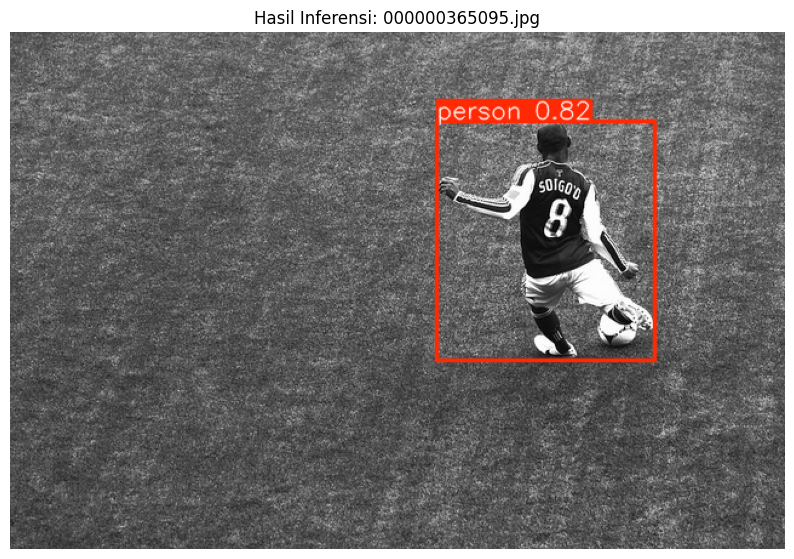


image 1/1 /content/yolo_person_dataset/images/val/images/val/000000212573.jpg: 576x640 3 persons, 62.1ms
Speed: 2.1ms preprocess, 62.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 640)


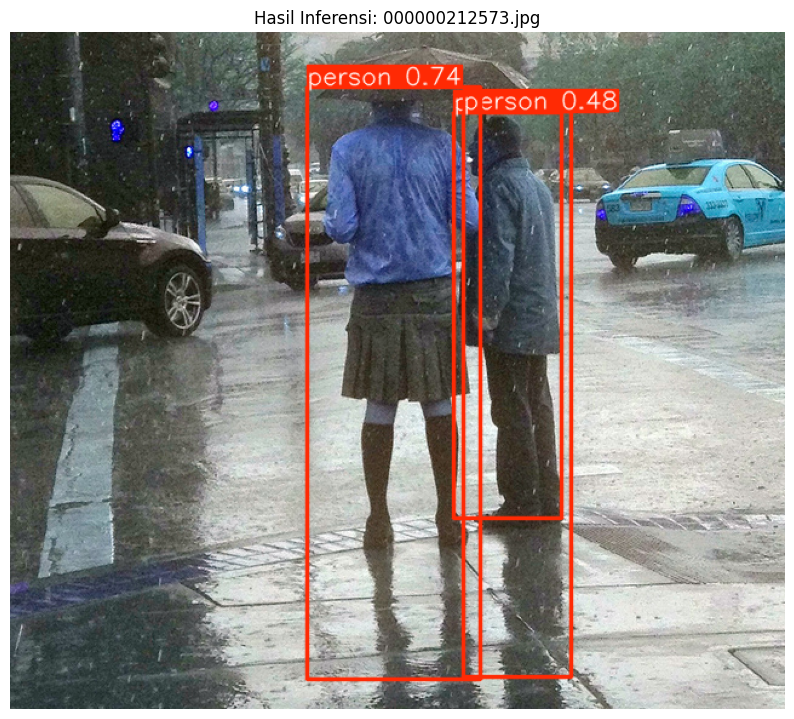


image 1/1 /content/yolo_person_dataset/images/val/images/val/000000289594.jpg: 640x544 1 person, 60.3ms
Speed: 2.3ms preprocess, 60.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


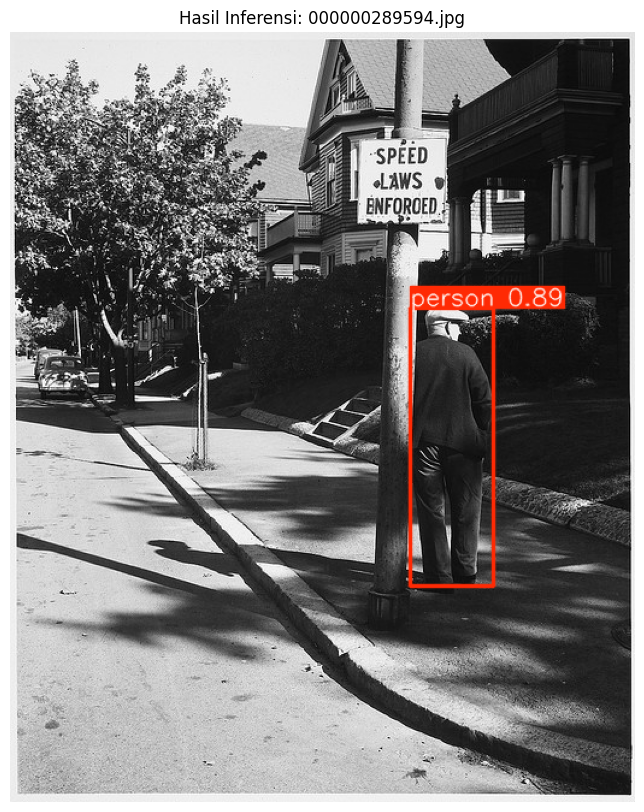


image 1/1 /content/yolo_person_dataset/images/val/images/val/000000286553.jpg: 480x640 3 persons, 62.3ms
Speed: 1.8ms preprocess, 62.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


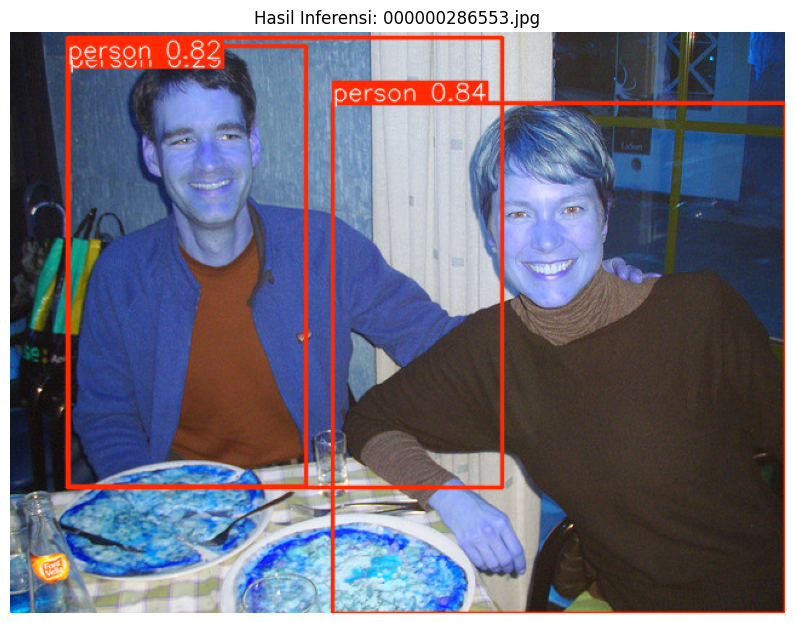


image 1/1 /content/yolo_person_dataset/images/val/images/val/000000192716.jpg: 640x544 (no detections), 17.0ms
Speed: 1.8ms preprocess, 17.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


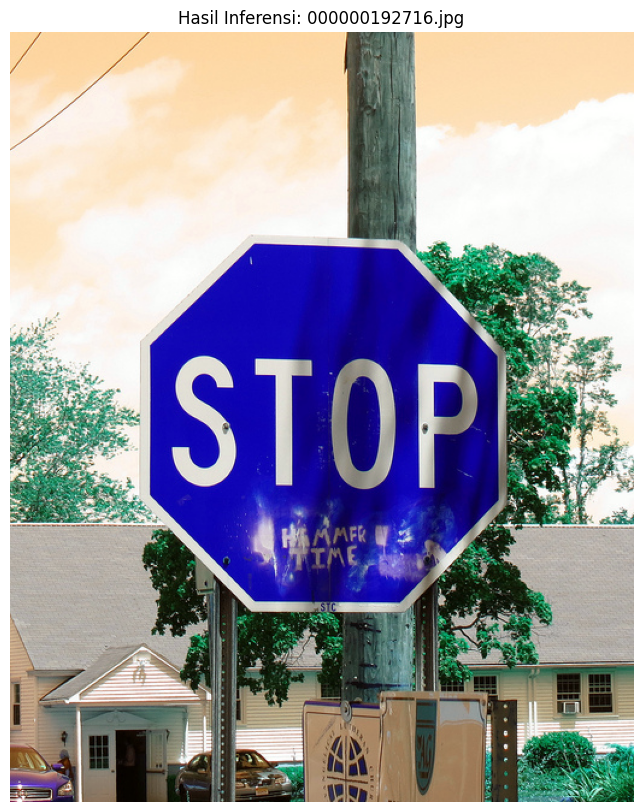

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

test_folder = "/content/yolo_person_dataset/images/val/images/val"

max_images = 5
count = 0

for img_file in os.listdir(test_folder):
    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(test_folder, img_file)

        results = model.predict(source=img_path, imgsz=640, save=False, save_txt=False)

        img_result = results[0].plot()

        plt.figure(figsize=(10, 10))
        plt.imshow(img_result)
        plt.axis('off')
        plt.title(f"Hasil Inferensi: {img_file}")
        plt.show()

        count += 1
        if count >= max_images:
            break



image 1/1 /content/test/test_yolo.jpg: 448x640 1 person, 13.9ms
Speed: 3.5ms preprocess, 13.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


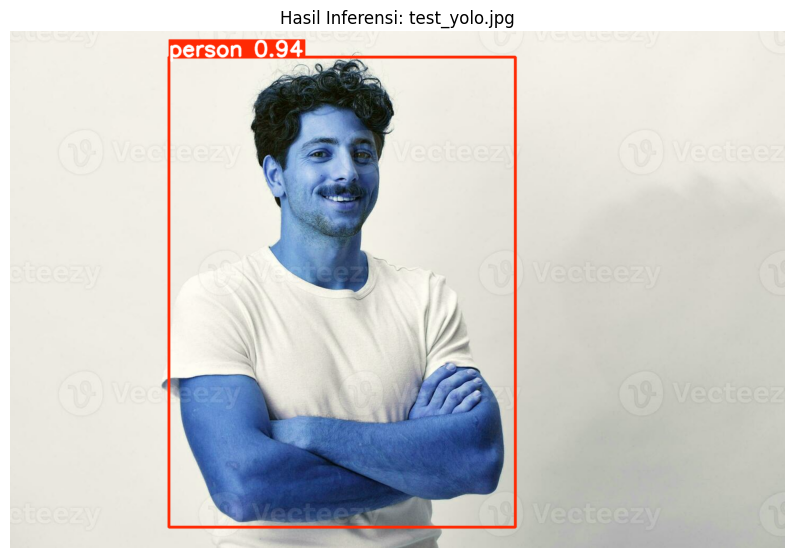

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

test_folder = "/content/test"

max_images = 5
count = 0

for img_file in os.listdir(test_folder):
    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(test_folder, img_file)

        results = model.predict(source=img_path, imgsz=640, save=False, save_txt=False)

        img_result = results[0].plot()

        plt.figure(figsize=(10, 10))
        plt.imshow(img_result)
        plt.axis('off')
        plt.title(f"Hasil Inferensi: {img_file}")
        plt.show()

        count += 1
        if count >= max_images:
            break
